In [1]:
import torch

from helper import linear_q_with_scale_and_zero_point, linear_dequantization, plot_quantization_errors

test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]])

## Finding `Scale` and `Zero Point` for Quantization
$r_{min}$ should map $q_{min}$ and $r_{max}$ should map $q_{max}$ and we get the equation:<br>
**$r_{min}$ = s($q_{min}$ – z) & $r_{max}$ = s($q_{max}$ – z)**

Subtract both the above equations:<br>
$r_{min}$ – $r_{max}$ = s($q_{max}$ – z) – s($q_{min}$ – z)<br>
$r_{min}$ – $r_{max}$ = s($q_{max}$ – $q_{min}$ – z + z)<br>
$r_{max}$ – $r_{min}$ = s($q_{max}$ – $q_{min}$)<br>
s = ($r_{max}$ – $r_{min}$) / ($q_{max}$ – $q_{min}$)<br>

For the zero point z, we need to round the value since it is a n-bit integer:<br>
$r_{min}$ = s($q_{min}$ – z)<br>
$r_{min}$ = s.$q_{min}$ – s.z<br>
$s.z = s.q_{min} – r_{min}$<br>
$z = q_{min} – r_{min} /s$<br>
$z = int(round(q_{min} – r_{min}/s))$<br>


$$
\begin{bmatrix}
191.6 & -13.5 & 728.6 \\
92.14 & 295.5 & -184 \\
0 & 684.6 & 245.5
\end{bmatrix}
$$

[$r_{min}$, $r_{max}$] = $[-184, 728.6]$<br>
[$q_{min}$, $q_{max}$] = $[-128, 127]$<br>
$s = (728.6 - (-184))/(127 - (-128)) = 3.58$<br>
$z = int(round((-128)-(-184)/3.58)) = -77$<br>

### Why make z an integer?
The goal behind this choice is to represent zero in the original range as an integer in the quantized range. So when we quantize zero it will take the value z in the quantized range and if we dequantize the value z, it will become zero again.

### What if z is out of range?
Since we need to cast z to the quantized data type.<br>
If z < $q_{min}$ then z = $q_{min}$<br>
If z > $q_{max}$ then z = $q_{max}$<br>
So this way we don’t have overflow and underflow.

In [2]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max

In [3]:
q_min

-128

In [4]:
q_max

127

In [5]:
r_min = test_tensor.min().item()

In [6]:
r_min

-184.0

In [7]:
r_max = test_tensor.max().item()

In [8]:
r_max

728.5999755859375

In [9]:
scale = (r_max - r_min) / (q_max - q_min)

In [10]:
scale

3.578823433670343

In [11]:
zero_point = q_min - (r_min / scale)

In [12]:
zero_point

-76.58645490333825

In [13]:
zero_point = int(round(zero_point))

In [14]:
zero_point

-77

Putting all the above logic into a function.

In [15]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)

    zero_point = q_min - (r_min / scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    
    return scale, zero_point

In [16]:
new_scale, new_zero_point = get_q_scale_and_zero_point(test_tensor)

In [17]:
new_scale

3.578823433670343

In [18]:
new_zero_point

-77

Using the calculated `scale` and `zero_point` with the functions `linear_q_with_scale_and_zero_point` and `linear_dequantization`.

In [19]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, new_scale, new_zero_point)

In [20]:
dequantized_tensor = linear_dequantization(quantized_tensor, new_scale, new_zero_point)

- Plot to see how the Quantization Error looks like after using calculated `scale` and `zero_point`.

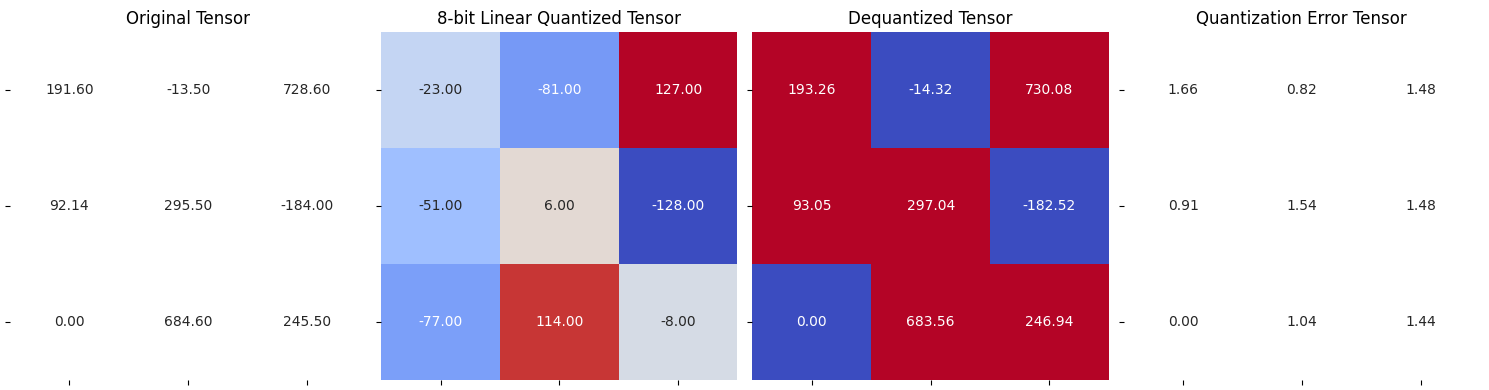

In [21]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [22]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

### Put Everything Together: Your Own Linear Quantizer

- Now, put everything togther to make your own Linear Quantizer.

In [23]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, dtype=dtype)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype=dtype)
    
    return quantized_tensor, scale , zero_point

In [24]:
r_tensor = torch.randn((4, 4))

In [25]:
r_tensor

tensor([[ 0.4932,  0.5593,  0.3367, -0.5350],
        [-0.2344, -0.2833, -0.2291,  0.7843],
        [-2.1898, -0.2059, -0.7546,  0.8257],
        [ 0.1114,  0.2245, -0.4224, -0.0353]])

In [26]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [27]:
quantized_tensor

tensor([[  99,  104,   85,   12],
        [  37,   33,   38,  123],
        [-128,   40,   -7,  127],
        [  66,   76,   21,   54]], dtype=torch.int8)

In [28]:
scale

0.0118255521736893

In [29]:
zero_point

57

In [30]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

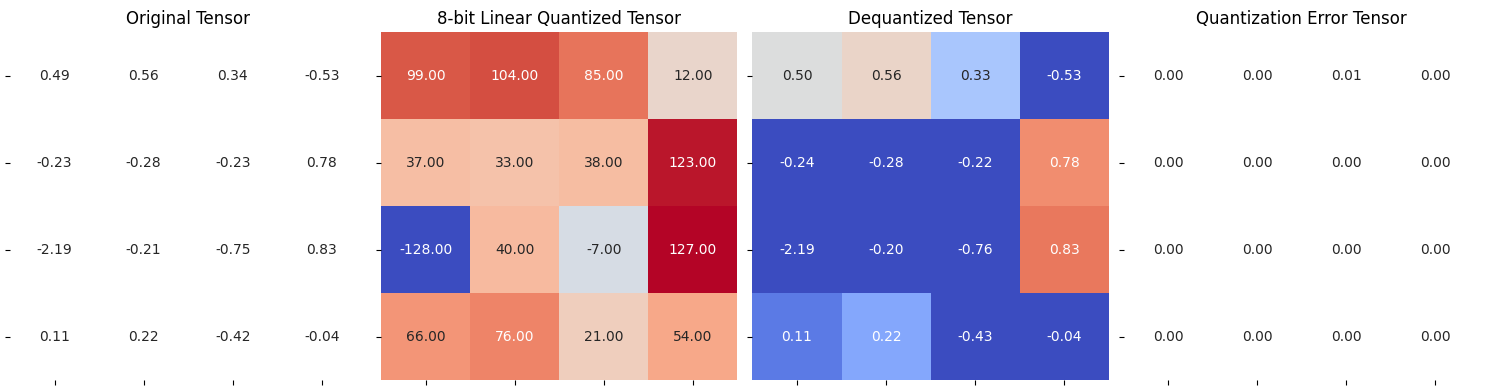

In [31]:
plot_quantization_errors(r_tensor, quantized_tensor, dequantized_tensor)

In [32]:
(dequantized_tensor-r_tensor).square().mean()

tensor(1.0914e-05)